In [1]:
%matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
             
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [2]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 

In [3]:
dfOmikron = pd.read_excel(rootdir_data+'Omikron.xlsx')
dfOmikron.Dato = pd.to_datetime(dfOmikron.Dato)


latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir

df = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',delimiter=';',encoding='latin1')
df['Prøvedato'] =  pd.to_datetime(df['Prøvedato'],format='%Y-%m-%d')

df = df[df.Region == 'Hovedstaden']
dfTot = df.groupby('Prøvedato').sum()
dfRe = df[df['Type af tilfælde (reinfektion eller første infektion)'] == '1.Reinfektion'].groupby('Prøvedato').sum()


In [4]:
dfOmikronShort = dfOmikron.iloc[1:45]
dfOmikronShort
oDay = dfOmikronShort.Dato 
oRate = dfOmikronShort.Ratio/100

# Extend in both directions
preDay = np.arange(dfTot.index[0],oDay.iloc[0],np.timedelta64(1,'D'))
preRate = np.zeros(preDay.shape)

postDay = np.arange(oDay.iloc[-1],dfTot.index[-1],np.timedelta64(1,'D'))
postRate = np.ones(postDay.shape)

# Concatenate arrays
oDay = np.concatenate([preDay,oDay,postDay])
oRate = np.concatenate([preRate,oRate,postRate])

In [5]:

oRate = np.concatenate([[0,0,0],pf.rnMean(oRate,7),[1,1,1]])

In [6]:
dfToUse = pd.DataFrame() 
dfToUse['Date'] = dfTot.index 
dfToUse['Total'] = (dfTot.infected ).values
dfToUse['Delta'] = (dfTot.infected*(1-oRate)).values
dfToUse['Omikron'] = (dfTot.infected*oRate).values
dfToUse['Reinfections'] = (dfRe.infected  ).values

df = dfToUse.copy()

(18901.0, 19071.1)

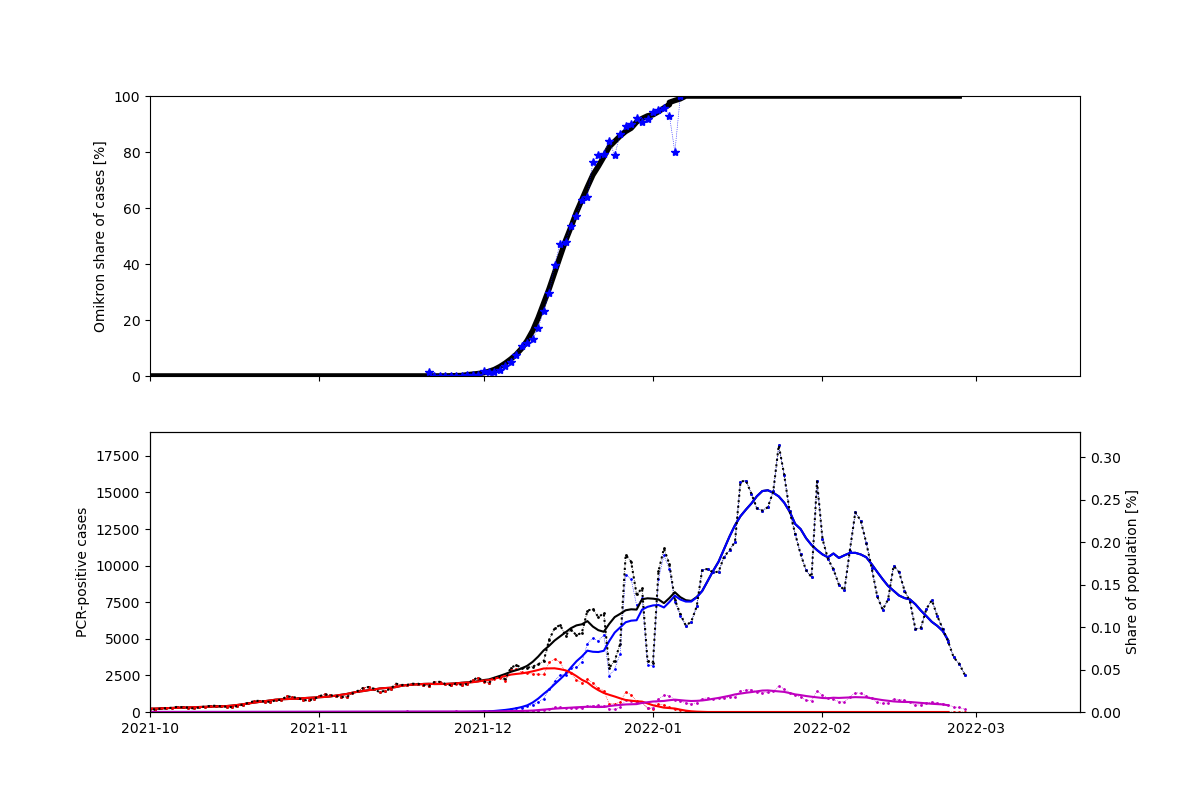

In [7]:
fig,(ax2,ax1) = plt.subplots(2,1,sharex=True)
ax2.plot(oDay,100*oRate,'k',linewidth=4,label='Ratio of Omikron-cases (running mean)')
# ax2.plot(rnTime(oDay,7),rnMean(oRate,7))
ax2.plot(dfOmikron.Dato,dfOmikron.Ratio,'b*:',linewidth=0.5,label='Daily ratio (data)')

ax1_1 = ax1.twinx()
DKpop = 5800000
ax1_1.plot(dfTot.index,100*dfTot.infected/DKpop,'k:')
ax1.plot(dfTot.index,dfTot.infected,'k.:',markersize=2,linewidth=0.5,label='Total cases')
ax1.plot(dfTot.index,dfTot.infected*oRate,'b.:',markersize=2,linewidth=0.5,label='Omikron cases')
ax1.plot(dfTot.index,dfTot.infected*(1-oRate),'r.:',markersize=2,linewidth=0.5,label='Delta cases')
ax1.plot(dfRe.index,dfRe.infected,'m.:',markersize=2,linewidth=0.5,label='Reinfections')

ax1.plot(pf.rnTime(dfTot.index),pf.rnMean(dfTot.infected),'k')
ax1.plot(pf.rnTime(dfTot.index),pf.rnMean(dfTot.infected*oRate),'b')
ax1.plot(pf.rnTime(dfTot.index),pf.rnMean(dfTot.infected*(1-oRate)),'r')
ax1.plot(pf.rnTime(dfRe.index),pf.rnMean(dfRe.infected),'m')


ax1.set_ylim(bottom=0)
ax1_1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0,top=100)


ax2.set_ylabel('Omikron share of cases [%]')
ax1.set_ylabel('PCR-positive cases')
ax1_1.set_ylabel('Share of population [%]')

ax1.set_xlim(left=np.datetime64('2021-10'))

# Setup model

In [8]:

df = df[df.Date >= np.datetime64('2021-10-01')]
# df = df[df.Date >= np.datetime64('2021-09-15')]
df = df.reset_index()
DateRestrictions = np.where(df.Date == np.datetime64('2021-12-15'))[0][0]
DateNewYears = np.where(df.Date == np.datetime64('2022-01-01'))[0][0]
DateRestrictionsEnd = np.where(df.Date == np.datetime64('2022-01-15'))[0][0]



In [9]:
# Reload PandemiXModelFunctions, in case changes have been made
import importlib 
importlib.reload(pmf)

<module 'PandemiXModelFunctions' from 'c:\\Users\\rakrpe\\GithubRepos\\PandemiX\\modelling\\PandemiXModelFunctions.py'>

In [10]:
# Initialize everything
DarkNumberRatio = 1.25
DarkNumberRatio = 1
DarkNumberRatio = 2

# DKpop = 5800000
# # Numbers for weeks 44, i.e. 2021-11-01
# numVacc = 4423398
# DKpop = 5889508


# Numbers from 2021-11-01 for Region Hovedstaden
popCount = 1857872
numVacc = 1365172
preInf = 183799
preInf = preInf * 0.95

# iniInf = DarkNumberRatio * df.Total[0:5].sum()/DKpop
# iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:5]).sum()/DKpop
iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:6]).sum()/DKpop
# iniVacc = 0.7 # Approximately DK's vaccinationsrate at the end of summer 2021
iniVacc = numVacc/popCount 
# iniImmu = 0.05 # Approximation. Should only be "natural immunity"
iniImmu = DarkNumberRatio * (preInf/popCount)
# iniImmu = 0.10 # Approximation. Should only be "natural immunity"
iniImmu = iniImmu * (1-iniVacc) # For splitting previous infections between vaccinated and susceptible

iniVacc = iniVacc * 0.95 # Assuming approximately 5% of vaccinations didn't provide immunity
# iniVacc = iniVacc * 0.925 # Assuming approximately 7.5% of vaccinations didn't provide immunity

V_0 = iniVacc 
IS_0 = 0
IV_0 = 0
Y_0 = iniInf
R01_0 = iniImmu
R10_0 = 0
I01_0 = 0
Y10_0 = 0
S_0 = 1 - V_0 - IS_0 - IV_0 - Y_0 - R01_0 - R10_0 - I01_0 - Y10_0 

init = {'S' : S_0,'V' : V_0,'IS' : IS_0,'IV' : IV_0,'Y' : Y_0,'R01' : R01_0,'R10' : R10_0,'I01' : I01_0,'Y10' : Y10_0}

# gammas = 1/7
gammas = 1/4.7
# gammas = 1/3.5
# gammas = 1/(5.5)
# gammas = 1/(2)
# beta_Y = 4.2*gammas
beta_Y = 4.5*gammas
beta_Y = 4.8*gammas
# beta_Y = 6.9*gammas
# beta_Y = 7.2*gammas
beta_I = 2*gammas
# beta_I = 1.5*gammas

pars = {'beta_IS_S' : beta_I,'beta_IV_S' : beta_I,'beta_I01_S' : beta_I,'beta_IS_V' : beta_I,'beta_IV_V' : beta_I,'beta_I01_V' : beta_I,'beta_IS_R01' : beta_I,'beta_IV_R01' : beta_I,'beta_I01_R01' : beta_I,'beta_Y_S' : beta_Y,'beta_Y10_S' : beta_Y,'beta_Y_R10' : beta_Y,'beta_Y10_R10' : beta_Y,'gamma_IS' : gammas,'gamma_IV' : gammas,'gamma_Y' : gammas,'gamma_I01' : gammas,'gamma_Y10' : gammas}

numDaysToSim = len(df.Date)    
tEnd = numDaysToSim+20
sch1 = pmf.Scheme('OmikronDeltaFull',init,pars,3,tEnd,Changes=[])


(0.0, 10000.0)

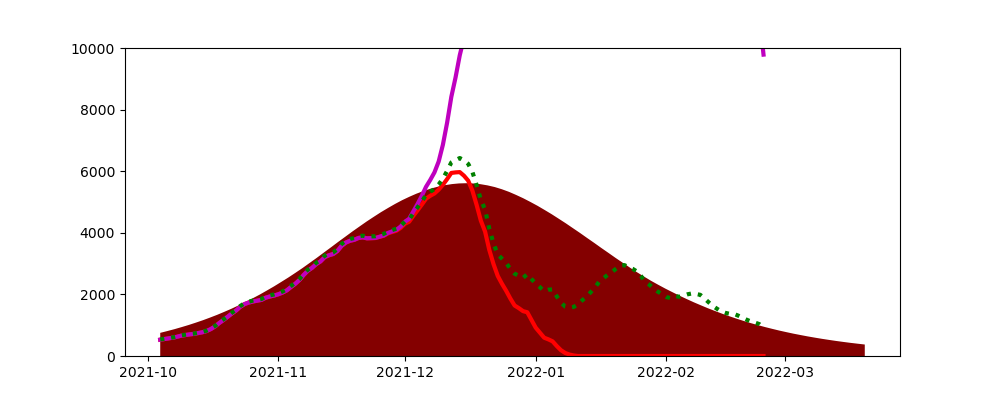

In [11]:
curSch = sch1
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))

fig,ax1 = plt.subplots(figsize=(10,4))

ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax1.set_ylim(top=10000,bottom=0)

In [12]:
# tLock = DateRestrictions
# # betaMult = 0.5
# # betaSet_Y_close = betaSet 
# # betaSet_I_close = betaSet 
# betaSet_Y_close = beta_Y * 0.5
# # betaSet_I_close = beta_I * 0.75
# betaSet_I_close = beta_I
# dictToSet = {'beta_IS_S' : betaSet_I_close,'beta_IV_S' : betaSet_I_close,'beta_I01_S' : betaSet_I_close,'beta_IS_V' : betaSet_I_close,'beta_IV_V' : betaSet_I_close,'beta_I01_V' : betaSet_I_close,'beta_IS_R01' : betaSet_I_close,'beta_IV_R01' : betaSet_I_close,'beta_I01_R01' : betaSet_I_close,'beta_Y_S' : betaSet_Y_close,'beta_Y10_S' : betaSet_Y_close,'beta_Y_R10' : betaSet_Y_close,'beta_Y10_R10' : betaSet_Y_close}
# betaSet = pmf.Change(tLock, SetParameters=dictToSet)

# sch2 = sch1.copy()
# sch2.addChange(betaSet)
# sch2.simulate()

In [13]:
tLock = DateRestrictions
betaMult_Y_close = 0.5
# betaMult_I_close = 0.625
betaMult_I_close = 0.75
dictToMult = {'beta_IS_S' : betaMult_I_close,'beta_IV_S' : betaMult_I_close,'beta_I01_S' : betaMult_I_close,'beta_IS_V' : betaMult_I_close,'beta_IV_V' : betaMult_I_close,'beta_I01_V' : betaMult_I_close,'beta_IS_R01' : betaMult_I_close,'beta_IV_R01' : betaMult_I_close,'beta_I01_R01' : betaMult_I_close,'beta_Y_S' : betaMult_Y_close,'beta_Y10_S' : betaMult_Y_close,'beta_Y_R10' : betaMult_Y_close,'beta_Y10_R10' : betaMult_Y_close}
betaMultChange = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)

In [14]:
tLock = DateRestrictions + 7
betaMult_Y_close = 1
betaMult_I_close = 0.8
dictToMult = {'beta_IS_S' : betaMult_I_close,'beta_IV_S' : betaMult_I_close,'beta_I01_S' : betaMult_I_close,'beta_IS_V' : betaMult_I_close,'beta_IV_V' : betaMult_I_close,'beta_I01_V' : betaMult_I_close,'beta_IS_R01' : betaMult_I_close,'beta_IV_R01' : betaMult_I_close,'beta_I01_R01' : betaMult_I_close,'beta_Y_S' : betaMult_Y_close,'beta_Y10_S' : betaMult_Y_close,'beta_Y_R10' : betaMult_Y_close,'beta_Y10_R10' : betaMult_Y_close}
betaMultChange2 = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)
sch2.addChange(betaMultChange2)

In [15]:
tLock = DateNewYears + 7
betaMult_Y_close = 1.05
betaMult_I_close = 1.05
dictToMult = {'beta_IS_S' : betaMult_I_close,'beta_IV_S' : betaMult_I_close,'beta_I01_S' : betaMult_I_close,'beta_IS_V' : betaMult_I_close,'beta_IV_V' : betaMult_I_close,'beta_I01_V' : betaMult_I_close,'beta_IS_R01' : betaMult_I_close,'beta_IV_R01' : betaMult_I_close,'beta_I01_R01' : betaMult_I_close,'beta_Y_S' : betaMult_Y_close,'beta_Y10_S' : betaMult_Y_close,'beta_Y_R10' : betaMult_Y_close,'beta_Y10_R10' : betaMult_Y_close}
betaMultChange3 = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)
sch2.addChange(betaMultChange2)
sch2.addChange(betaMultChange3)

In [16]:
tChange = 55
# tChange = 52
# tChange = 30
toAdd = iniInf/10
dictToAdd =  {  
    'S' : -toAdd,
    'IS' : toAdd,
}
addI = pmf.Change(tChange, AddVariables=dictToAdd)

tEnd = numDaysToSim+150
sch3 = sch2.copy()
sch3.addChange(addI)
sch3.sortChanges()
sch3.simulate()

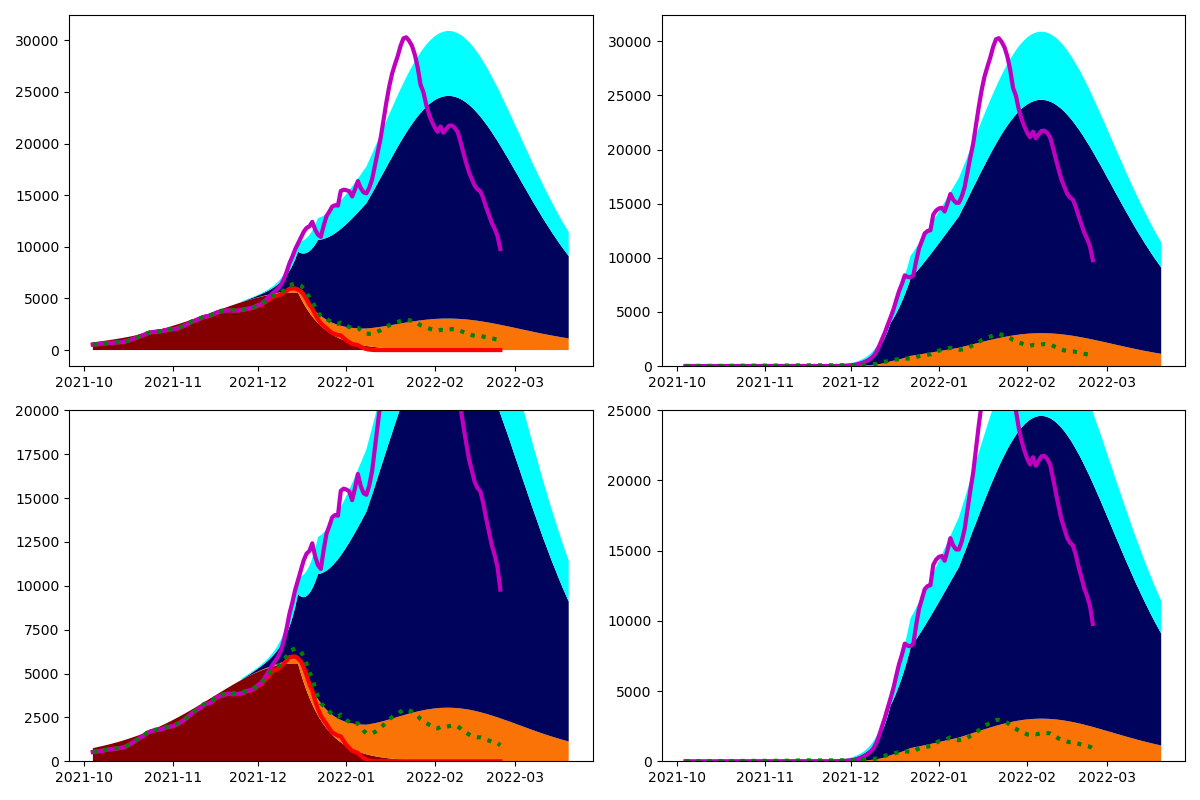

In [17]:
curSch = sch3
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))

fig,allAxes = plt.subplots(2,2)

ax1 = allAxes.flatten()[0]
ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax3 = allAxes.flatten()[2]
ax3.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax3.set_ylim(top=20000,bottom=0)



ax2 = allAxes.flatten()[1]
ax2.stackplot(curDays,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) ),':',color='g',linewidth=3)




ax4 = allAxes.flatten()[3]
ax4.stackplot(curDays,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) ),':',color='g',linewidth=3)

ax4.set_ylim(top=25000,bottom=0)

fig.tight_layout()

# New try

In [18]:
# Initialize everything
DarkNumberRatio = 1.5
# DarkNumberRatio = 1
# DarkNumberRatio = 2

# DKpop = 5800000
# # Numbers for weeks 44, i.e. 2021-11-01
# numVacc = 4423398
# DKpop = 5889508


# Numbers from 2021-11-01 for Region Hovedstaden
popCount = 1857872
numVacc = 1365172
preInf = 183799
preInf = preInf * 0.95

# iniInf = DarkNumberRatio * df.Total[0:5].sum()/DKpop
# iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:5]).sum()/DKpop
iniInf = DarkNumberRatio * (pf.rnMean(df.Total,7)[0:4]).sum()/DKpop
# iniVacc = 0.7 # Approximately DK's vaccinationsrate at the end of summer 2021
iniVacc = numVacc/popCount 
# iniImmu = 0.05 # Approximation. Should only be "natural immunity"
iniImmu = DarkNumberRatio * (preInf/popCount)
# iniImmu = 0.10 # Approximation. Should only be "natural immunity"
iniImmu = iniImmu * (1-iniVacc) # For splitting previous infections between vaccinated and susceptible

# iniVacc = iniVacc * 0.95 # Assuming approximately 5% of vaccinations didn't provide immunity
iniVacc = iniVacc * 0.925 # Assuming approximately 7.5% of vaccinations didn't provide immunity

V_0 = iniVacc 
IS_0 = 0
IV_0 = 0
Y_0 = iniInf
R01_0 = iniImmu
R10_0 = 0
I01_0 = 0
Y10_0 = 0
S_0 = 1 - V_0 - IS_0 - IV_0 - Y_0 - R01_0 - R10_0 - I01_0 - Y10_0 

init = {'S' : S_0,'V' : V_0,'IS' : IS_0,'IV' : IV_0,'Y' : Y_0,'R01' : R01_0,'R10' : R10_0,'I01' : I01_0,'Y10' : Y10_0}

# # gammas = 1/7
# gammas = 1/4.7
# gammas = 1/3.5
# gammas_I = gammas 
# gammas_Y = gammas
# # beta_Y = 4.2*gammas
# beta_Y = 4.3*gammas
# beta_Y =  4.8*gammas
# # beta_Y = 6.9*gammas
# # beta_Y = 7.2*gammas
# beta_I = 1.85*gammas
# # beta_I = 1.5*gammas

gammas_I = 1/4.7
gammas_Y = 1/3
# gammas = 1/(5.5)
# gammas = 1/(2)

beta_Y = 4.05*gammas_Y
beta_I = 1.9*gammas_I

pars = {'beta_IS_S' : beta_I,'beta_IV_S' : beta_I,'beta_I01_S' : beta_I,'beta_IS_V' : beta_I,'beta_IV_V' : beta_I,'beta_I01_V' : beta_I,'beta_IS_R01' : beta_I,'beta_IV_R01' : beta_I,'beta_I01_R01' : beta_I,'beta_Y_S' : beta_Y,'beta_Y10_S' : beta_Y,'beta_Y_R10' : beta_Y,'beta_Y10_R10' : beta_Y,'gamma_IS' : gammas_I,'gamma_IV' : gammas_I,'gamma_Y' : gammas_Y,'gamma_I01' : gammas_I,'gamma_Y10' : gammas_Y}

numDaysToSim = len(df.Date)    
tEnd = numDaysToSim+20
sch1 = pmf.Scheme('OmikronDeltaFull',init,pars,3,tEnd,Changes=[])


(0.0, 10000.0)

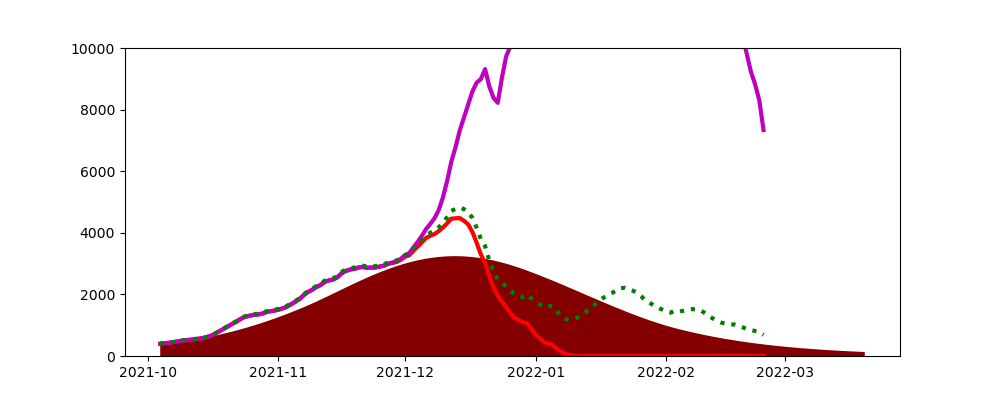

In [19]:
curSch = sch1
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))

fig,ax1 = plt.subplots(figsize=(10,4))

ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax1.set_ylim(top=10000,bottom=0)

In [20]:
tLock = DateRestrictions + 3
betaMult_Y_close = 0.5
# betaMult_I_close = 0.625
betaMult_I_close = 0.6
dictToMult = {'beta_IS_S' : betaMult_I_close,'beta_IV_S' : betaMult_I_close,'beta_I01_S' : betaMult_I_close,'beta_IS_V' : betaMult_I_close,'beta_IV_V' : betaMult_I_close,'beta_I01_V' : betaMult_I_close,'beta_IS_R01' : betaMult_I_close,'beta_IV_R01' : betaMult_I_close,'beta_I01_R01' : betaMult_I_close,'beta_Y_S' : betaMult_Y_close,'beta_Y10_S' : betaMult_Y_close,'beta_Y_R10' : betaMult_Y_close,'beta_Y10_R10' : betaMult_Y_close}
betaMultChange = pmf.Change(tLock, MultiplyParameters=dictToMult)

sch2 = sch1.copy()
sch2.addChange(betaMultChange)


In [21]:
tChange = 52
# tChange = 52
# tChange = 30
toAdd = iniInf/10
dictToAdd =  {  
    'S' : -toAdd,
    'IS' : toAdd,
}
addI = pmf.Change(tChange, AddVariables=dictToAdd)

tEnd = numDaysToSim+150
sch3 = sch2.copy()
sch3.addChange(addI)
sch3.sortChanges()
sch3.simulate()

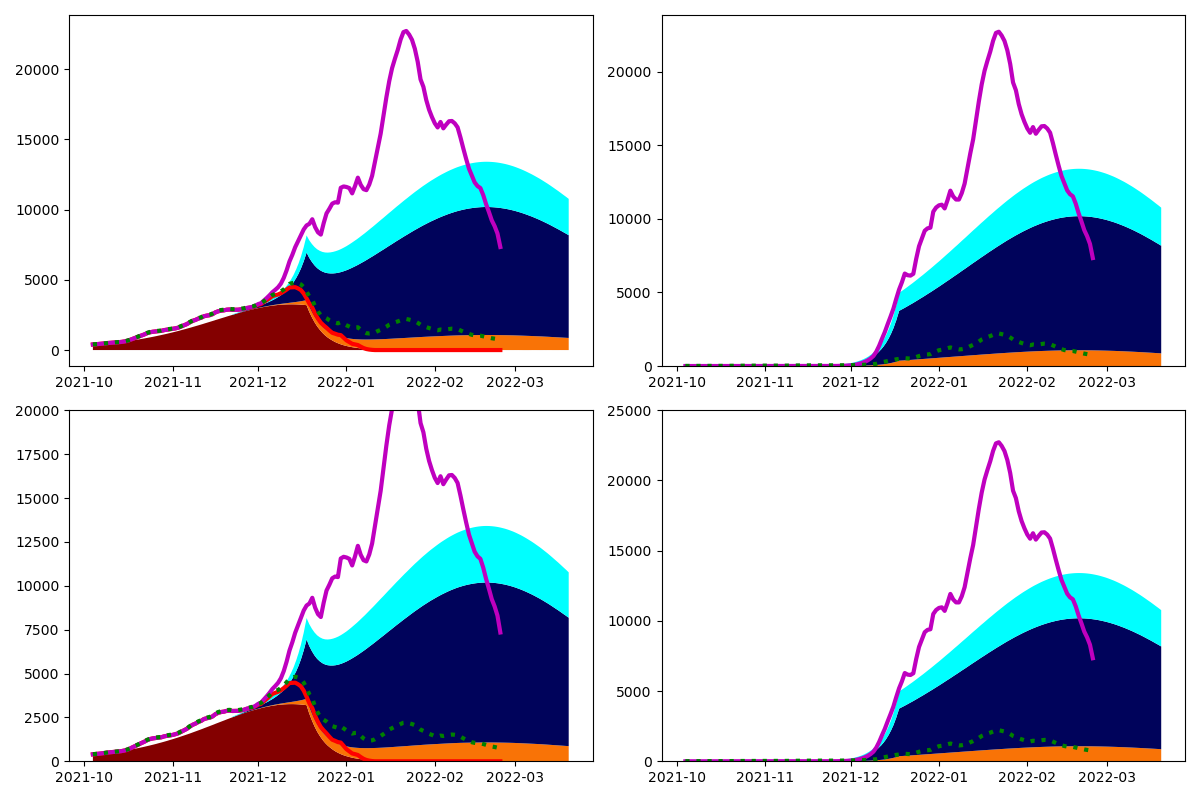

In [22]:
curSch = sch3
curSch.simulate()

curT = curSch.result.t
curDays = np.datetime64(df.iloc[0].Date)+np.array([np.timedelta64(int(np.round(x*24)),'h') for x in curT])

# plt.figure(figsize=(10,5))

fig,allAxes = plt.subplots(2,2)

ax1 = allAxes.flatten()[0]
ax1.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax1.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax3 = allAxes.flatten()[2]
ax3.stackplot(curDays,
                DKpop*gammas*curSch.result.Y,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:dark red','xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Delta,7) + pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax3.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) + pf.rnMean(df.Delta,7)),':',color='g',linewidth=3)

ax3.set_ylim(top=20000,bottom=0)



ax2 = allAxes.flatten()[1]
ax2.stackplot(curDays,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax2.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) ),':',color='g',linewidth=3)




ax4 = allAxes.flatten()[3]
ax4.stackplot(curDays,
                DKpop*gammas*curSch.result.I01,
                DKpop*gammas*curSch.result.IV,
                DKpop*gammas*curSch.result.IS,
                colors=['xkcd:orange','xkcd:dark blue','xkcd:cyan'],
                )
# ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio * pf.rnMean(df.Delta,7),color='r',linewidth=3)
ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Omikron,7)),color='m',linewidth=3)
ax4.plot(pf.rnTime(df.Date,7),DarkNumberRatio *( pf.rnMean(df.Reinfections,7) ),':',color='g',linewidth=3)

ax4.set_ylim(top=25000,bottom=0)

fig.tight_layout()